**# Data cleaning**

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
# 1. UNIVERSAL PATHING
# Adjust 'project_dataset' to your local folder name if different
data_folder = "project_dataset"
cash_path = os.path.join(data_folder, "extract - cash request - data analyst.csv")
fees_path = os.path.join(data_folder, "extract - fees - data analyst - .csv")



In [ ]:
# 2. LOADING DATA
cash_request = pd.read_csv(cash_path)
fees = pd.read_csv(fees_path)


In [ ]:

# 3. DATE CLEANING (Merged logic)
# Combining all date columns identified by the team
cash_date_cols = ["created_at", "updated_at", "moderated_at", "reimbursement_date",
                  "cash_request_received_date", "money_back_date", "send_at",
                  "reco_creation", "reco_last_update"]

fees_date_cols = ["created_at", "updated_at", "paid_at", "from_date", "to_date"]

# Apply conversion to cash_request
for col in cash_date_cols:
    if col in cash_request.columns:
        cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')

# Apply conversion to fees
for col in fees_date_cols:
    if col in fees.columns:
        fees[col] = pd.to_datetime(fees[col], errors='coerce')


In [ ]:

# 4. DATA INTEGRITY FIXES
# Ensure IDs are integers for proper merging later
fees["cash_request_id"] = fees["cash_request_id"].astype("Int64")
cash_request["user_id"] = cash_request["user_id"].astype("Int64")

print("✅ System Ready: Data loaded, dates converted, and IDs formatted.")

✅ System Ready: Data loaded, dates converted, and IDs formatted.


These columns were dropped: []


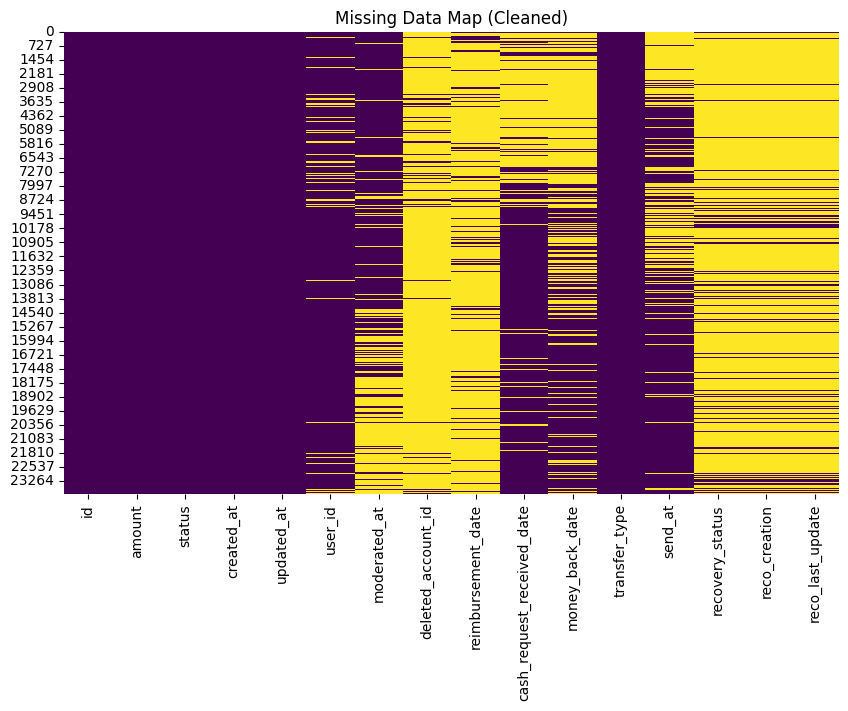

In [ ]:
#Identify and drop completely emppty columns
empty_cols = cash_request.columns[cash_request.isnull().all()]
cash_request_cleaned = cash_request.drop(columns=empty_cols)

print(f"These columns were dropped: {list(empty_cols)}")

#Take a look at the remaining missing data
plt.figure(figsize=(10, 6))
sns.heatmap(cash_request_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Map (Cleaned)')
plt.show()

In [ ]:
#Make sure created_at is in datime format
cash_request_cleaned['created_at'] =pd.to_datetime(cash_request_cleaned['created_at'], errors = 'coerce')

#first advance month for each user

cash_request_cleaned['cohort_month'] = cash_request_cleaned.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

#month of transaction
cash_request_cleaned['transaction_month']= cash_request_cleaned['created_at'].dt.to_period('M')

print("Cohorts, just the first 5 rows:")
print(cash_request_cleaned[['user_id', 'created_at', 'cohort_month', 'transaction_month']].head())

Cohorts, just the first 5 rows:
   user_id                       created_at cohort_month transaction_month
0      804 2019-12-10 19:05:21.596873+00:00      2019-12           2019-12
1      231 2019-12-10 19:50:12.347780+00:00      2019-12           2019-12
2      191 2019-12-10 19:13:35.825460+00:00      2019-12           2019-12
3      761 2019-12-10 19:16:10.880172+00:00      2019-12           2019-12
4     7686 2020-05-06 09:59:38.877376+00:00      2020-05           2020-05


/tmp/ipython-input-178146110.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request_cleaned['cohort_month'] = cash_request_cleaned.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
/tmp/ipython-input-178146110.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request_cleaned['transaction_month']= cash_request_cleaned['created_at'].dt.to_period('M')


In [ ]:
#How many unique cohorts?
unique_cohorts = cash_request_cleaned['cohort_month'].unique()

# sort them by time
unique_cohorts = sorted(unique_cohorts)

print(f'There are {len(unique_cohorts)} unique cohorts.')
print('Cohort list:')
for cohort in unique_cohorts:
    print(f'-{cohort}')

There are 14 unique cohorts.
Cohort list:
-2019-11
-2019-12
-2020-05
-2020-06
-NaT
-2020-01
-2020-02
-2020-03
-2020-04
-2020-07
-2020-08
-2020-09
-2020-10
-2020-11


In [ ]:
##What is this NaT, not a time? Maybe we missed something when cleaning?

float64


In [ ]:
Project Status & Next Steps
Current Progress:

Initial data cleaning is complete; completely empty columns have been dropped.

Date columns have been converted to datetime objects.

Preliminary cohorts have been defined using the first created_at month per user.

Note: We have 14 unique cohorts, including a NaT group that needs investigation for data quality reporting.

Next Steps for the Team:

Revenue Integration: Merge the fees data into the cash_request_cleaned dataframe. We need to group fees by cash_request_id and sum the total_amount first to avoid duplicating rows during the merge.

Incident Rate Calculation: Identify "incidents" within the fees table (look for type == 'incident' or specific status flags) to calculate the Incident Rate per cohort.

Retention/Frequency Matrix: Create a pivot table showing the number of active users in each cohort over the subsequent months to calculate the Frequency of Service Usage.

Data Quality Report: Document why we have NaT values and how many users are affected to fulfill the Data Quality Analysis requirement.

In [ ]:
# First cash request date per user
user_first = (
    cash_request.groupby("user_id", as_index=False)["created_at"]
    .min()
    .rename(columns={"created_at": "first_cash_request_at"})
)

# Cohort = month of first request
user_first["cohort"] = user_first["first_cash_request_at"].dt.to_period("M")

user_first.head()

/tmp/ipython-input-2752800195.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  user_first["cohort"] = user_first["first_cash_request_at"].dt.to_period("M")


,user_id,first_cash_request_at,cohort
0,34,2020-04-20 15:50:21.187257+00:00,2020-04
1,35,2019-12-13 20:27:38.106778+00:00,2019-12
2,47,2019-11-19 13:57:53.511561+00:00,2019-11
3,52,2019-12-17 09:01:12.584634+00:00,2019-12
4,53,2019-12-21 11:39:03.844436+00:00,2019-12


In [ ]:
# First cash request date per user
user_first = (
    cash.groupby("user_id", as_index=False)["created_at"]
    .min()
    .rename(columns={"created_at": "first_cash_request_at"})
)

# Cohort = month of first request
user_first["cohort"] = user_first["first_cash_request_at"].dt.to_period("M")

user_first.head()

In [ ]:
fees_paid = fees[fees["paid_at"].notna()].copy()

# If total_amount is text, ensure numeric
fees_paid["total_amount"] = pd.to_numeric(fees_paid["total_amount"], errors="coerce").fillna(0)

fees_paid.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00:00,2020-12-17 14:50:07.470110+00:00,NaT,NaT,after
1,6961,11714,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00:00,2020-12-08 17:13:10.459080+00:00,NaT,NaT,after
2,16296,23371,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00:00,2020-11-04 19:34:37.432910+00:00,NaT,NaT,after
3,20775,26772,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00:00,2020-11-19 05:09:22.500223+00:00,NaT,NaT,after
4,11242,19350,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00:00,2020-11-02 14:45:20.355598+00:00,NaT,NaT,after


In [ ]:
# Join fees to cash requests to get user_id
df = fees_paid.merge(
    cash_request[["id", "user_id", "created_at"]],
    left_on="cash_request_id",
    right_on="id",
    how="left",
    suffixes=("_fee", "_cash")
)

# Add cohort info
df = df.merge(
    user_first[["user_id", "cohort"]],
    on="user_id",
    how="left"
)

df.head()

,id_fee,cash_request_id,type,status,category,total_amount,reason,created_at_fee,updated_at,paid_at,from_date,to_date,charge_moment,id_cash,user_id,created_at_cash,cohort
0,6537,14941,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00:00,2020-12-17 14:50:07.470110+00:00,NaT,NaT,after,14941,35661,2020-09-07 10:46:57.780263+00:00,2020-09
1,6961,11714,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00:00,2020-12-08 17:13:10.459080+00:00,NaT,NaT,after,11714,16158,2020-08-10 13:15:54.291488+00:00,2020-06
2,16296,23371,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00:00,2020-11-04 19:34:37.432910+00:00,NaT,NaT,after,23371,81575,2020-10-23 10:10:43.278601+00:00,2020-10
3,20775,26772,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00:00,2020-11-19 05:09:22.500223+00:00,NaT,NaT,after,26772,94393,2020-10-31 15:46:14.156730+00:00,2020-10
4,11242,19350,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00:00,2020-11-02 14:45:20.355598+00:00,NaT,NaT,after,19350,<NA>,2020-10-06 00:40:24.008752+00:00,NaT


In [ ]:
# Drop invalid rows
df = df.dropna(subset=["paid_at", "cohort"])

# Ensure correct types
df["cohort"] = df["cohort"].astype("period[M]")
df["revenue_month"] = df["paid_at"].dt.to_period("M")

# Calculate months since cohort safely
df["cohort_month"] = (df["revenue_month"] - df["cohort"]).apply(lambda x: x.n)

# Keep valid timeline only
df = df[df["cohort_month"] >= 0]

/tmp/ipython-input-1765691300.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["revenue_month"] = df["paid_at"].dt.to_period("M")


In [ ]:
df[["user_id", "cohort", "paid_at", "revenue_month", "cohort_month", "total_amount"]].head()

,user_id,cohort,paid_at,revenue_month,cohort_month,total_amount
0,35661,2020-09,2020-12-17 14:50:07.470110+00:00,2020-12,3,5.0
1,16158,2020-06,2020-12-08 17:13:10.459080+00:00,2020-12,6,5.0
2,81575,2020-10,2020-11-04 19:34:37.432910+00:00,2020-11,1,5.0
3,94393,2020-10,2020-11-19 05:09:22.500223+00:00,2020-11,1,5.0
5,90386,2020-10,2020-11-09 19:10:14.474070+00:00,2020-11,1,5.0


In [ ]:
#Aggregate: total revenue by cohort x month
cohort_revenue = (
    df.groupby(["cohort", "cohort_month"], as_index=False)["total_amount"]
    .sum()
    .rename(columns={"total_amount": "revenue"})
)

cohort_revenue.head()

,cohort,cohort_month,revenue
0,2019-11,8,5.0
1,2019-11,10,5.0
2,2019-11,11,10.0
3,2019-11,12,5.0
4,2019-12,6,10.0


In [ ]:
cohort_matrix = cohort_revenue.pivot_table(
    index="cohort",
    columns="cohort_month",
    values="revenue",
    aggfunc="sum",
    fill_value=0
).sort_index()

cohort_matrix

cohort_month,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2019-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,10.0,5.0
2019-12,0.0,0.0,0.0,0.0,0.0,0.0,10.0,55.0,130.0,210.0,295.0,245.0,55.0
2020-01,0.0,0.0,0.0,0.0,0.0,10.0,55.0,45.0,90.0,145.0,70.0,40.0,35.0
2020-02,0.0,0.0,0.0,0.0,20.0,30.0,45.0,125.0,210.0,170.0,10.0,0.0,5.0
2020-03,0.0,0.0,0.0,20.0,55.0,40.0,105.0,175.0,140.0,20.0,5.0,5.0,0.0
2020-04,0.0,0.0,45.0,125.0,115.0,310.0,470.0,260.0,225.0,20.0,0.0,0.0,0.0
2020-05,0.0,95.0,360.0,340.0,655.0,1005.0,600.0,255.0,75.0,20.0,0.0,0.0,0.0
2020-06,430.0,1265.0,1070.0,2700.0,3930.0,2600.0,1080.0,285.0,110.0,0.0,0.0,0.0,0.0
2020-07,695.0,1080.0,2370.0,3545.0,2330.0,855.0,215.0,140.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cohort_matrix.style.format("{:,.2f}")

cohort_month,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2019-11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,5.00,10.00,5.00
2019-12,0.00,0.00,0.00,0.00,0.00,0.00,10.00,55.00,130.00,210.00,295.00,245.00,55.00
2020-01,0.00,0.00,0.00,0.00,0.00,10.00,55.00,45.00,90.00,145.00,70.00,40.00,35.00
2020-02,0.00,0.00,0.00,0.00,20.00,30.00,45.00,125.00,210.00,170.00,10.00,0.00,5.00
2020-03,0.00,0.00,0.00,20.00,55.00,40.00,105.00,175.00,140.00,20.00,5.00,5.00,0.00
2020-04,0.00,0.00,45.00,125.00,115.00,310.00,470.00,260.00,225.00,20.00,0.00,0.00,0.00
2020-05,0.00,95.00,360.00,340.00,655.00,"1,005.00",600.00,255.00,75.00,20.00,0.00,0.00,0.00
2020-06,430.00,"1,265.00","1,070.00","2,700.00","3,930.00","2,600.00","1,080.00",285.00,110.00,0.00,0.00,0.00,0.00
2020-07,695.00,"1,080.00","2,370.00","3,545.00","2,330.00",855.00,215.00,140.00,0.00,0.00,0.00,0.00,0.00
